### This notebook is used for evalution the performance of the trained fastText model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import fastText
from fastText import load_model

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# read in data
empathies = pd.read_csv('./empathies.csv')
msg = pd.read_csv('./msg_fasttext.csv')
msg.shape

(3561, 6)

In [3]:
# drop irrelevant columns
msg = msg.drop(msg.columns[0:2], axis=1)

In [4]:
# get a map that contains empathy and its corresponding polarity score, this map will be used to compute metrics
dict_polarities = {}
for i in range(empathies.shape[0]):
    dict_polarities['__label__'+empathies.iloc[i][0]] = float(empathies.iloc[i][1])

In [5]:
msg.head(2)

,num_seen,message,empathy,labels
0,3,slightly annoyed,annoyed,__label__annoyed
1,1,"i'm not feeling too bad, i have work tomorrow...",anxious,__label__anxious


In [6]:
# load trained fastText model
model = load_model('../fastText/test/model_woebot_epoch30_3gram.bin')

The following function is used to compare against the ground truth in a **relaxed**  format, which means if the predicted class is not exactly the same as the truth, but has the same polarity score. The prediction will still be counted as truth positive

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [7]:
def compare_truth_relaxed(cutoff_value, dict_polarities, model, inputs, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
        
    for i in range(start, stop):
        preds = model.predict(inputs.iloc[i][1].replace('\n', ' '), 5)
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['labels'].split(' ') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        
        for lab, p in zip(preds[0], preds[1]):
            if p > cutoff_value:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                
                if lab in msg.iloc[i]['labels'] or dict_polarities[lab] in true_scores:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['labels'] and dict_polarities[lab] not in true_scores:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['labels'].split(' '):
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs and dict_polarities[lab] not in scores:
                # false negative
                res[true_lab][2] += 1
                
    return res

Similiar as the above function. The following function is used to compare against the ground truth, but in a **nonrelaxed** format -- the predicted class has to be exactly the same as the truth in order to be counted as true positive.

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [8]:
def compare_truth_nonrelaxed(cutoff_value, dict_polarities, model, inputs, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
        
    for i in range(start, stop):
        preds = model.predict(inputs.iloc[i]['message'].replace('\n', ' '), 5)
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['labels'].split(' ') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        
        for lab, p in zip(preds[0], preds[1]):
            if p > cutoff_value:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                
                if lab in msg.iloc[i]['labels']:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['labels']:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['labels'].split(' '):
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs:
                # false negative
                res[true_lab][2] += 1
                
    return res

In [9]:
def overall_score(res):
    '''
    output precision, recall and F1 score
    '''
    num_TP, num_FP, num_FN = 0, 0, 0
    
    for _, vals in res.items():
        num_TP += vals[0]
        num_FP += vals[1]
        num_FN += vals[2]
            
    precision = num_TP/(num_TP+num_FP)
    recall = num_TP/(num_TP+num_FN)
    
    return precision, recall, 2/(1/precision + 1/recall)

In [10]:
# explore the best cutoff value with the training data
ps, rs, fs = [], [], []
for proposed_cut in np.arange(.0, .5, .01):
    res = compare_truth_relaxed(proposed_cut, dict_polarities, model, msg, 0, 2500)
    p, r, f = overall_score(res)
    ps.append(p)
    rs.append(rs)
    fs.append(f)

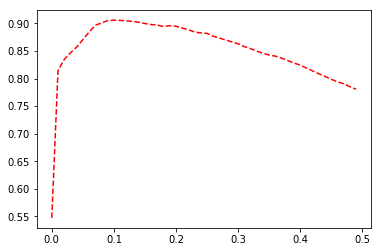

In [11]:
# plot the change of F1 score as the cutoff value increases from 0.0 to 0.5
proposed_cuts = np.arange(.0, .5, .01)
plt.plot(proposed_cuts, fs, 'r--')
plt.show()

In [12]:
# find the best cutoff value
max_fs_idx = fs.index(max(fs))
np.arange(.0, .5, .01)[max_fs_idx]

0.10000000000000001

In [14]:
# calculate overall precision, recall and F1 score of validation data with the cutoff value found from above
res = compare_truth_relaxed(.1, dict_polarities, model, msg, 2500, msg.shape[0])
overall_scores = overall_score(res)

print('model performance on the validation dataset is: ')
print('precision: {}'.format(overall_scores[0]))
print('recall: {}'.format(overall_scores[1]))
print('F1: {}'.format(overall_scores[2]))

model performance on the validation dataset is: 
precision: 0.9139026111503176
recall: 0.9011830201809325
F1: 0.9074982480728802


In [15]:
# generate bar-chart of true positives, false positives and false negatives for each class
def confu_plot(con_matrix):
    '''
    generate bar-chart of true positives, false positives and false negatives for each class
    '''
    names = []
    TP, FP, FN = [], [], []
    for k, vals in con_matrix.items():
        name=k.replace('__label__', '')
        names.append(name)
        TP.append(vals[0])
        FP.append(vals[1])
        FN.append(vals[2])

    trace1 = go.Bar(
        x=names,
        y=TP,
        name='True Positive'
    )

    trace2 = go.Bar(
        x=names,
        y=FP,
        name='False Positive'
    )

    trace3 = go.Bar(
        x=names,
        y=FN,
        name='False Negative'
    )

    data = [trace1, trace2, trace3]
    layout = go.Layout(
        barmode='group',

        xaxis=dict(
            title='labels',
            titlefont=dict(
                size=18,
            ),
            showticklabels=True,
            tickangle=45,
            tickfont=dict(
                size=14,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='grouped-bar') 

In [16]:
# plotting
confu_plot(res)

In [17]:
# explore the best cutoff value with the training data using the non-relaxed comparison function
ps, rs, fs = [], [], []
for proposed_cut in np.arange(.0, .5, .01):
    res = compare_truth_nonrelaxed(proposed_cut, dict_polarities, model, msg, 0, 2500)
    p, r, f = overall_score(res)
    ps.append(p)
    rs.append(rs)
    fs.append(f)

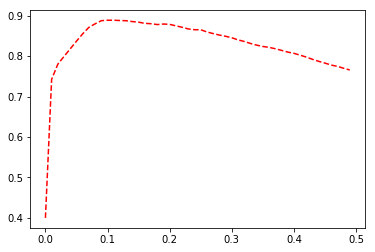

In [18]:
# plot the change of F1 score as the cutoff value increases from 0.0 to 0.5
proposed_cuts = np.arange(.0, .5, .01)
plt.plot(proposed_cuts, fs, 'r--')
plt.show()

In [19]:
# find the best cutoff value
max_fs_idx = fs.index(max(fs))
np.arange(.0, .5, .01)[max_fs_idx]

0.10000000000000001

In [22]:
# calculate overall precision, recall and F1 score of validation data with the cutoff value found from above
res = compare_truth_nonrelaxed(.1, dict_polarities, model, msg, 2500, msg.shape[0])
overall_scores = overall_score(res)

print('model performance using non-relaxed comparison function on the validation dataset is: ')
print('precision: {}'.format(overall_scores[0]))
print('recall: {}'.format(overall_scores[1]))
print('F1: {}'.format(overall_scores[2]))

model performance using non-relaxed comparison function on the validation dataset is: 
precision: 0.8983768525052929
recall: 0.8840277777777777
F1: 0.8911445572278615


In [23]:
confu_plot(res)

### test model performance on misspelling

In [24]:
model.predict('hungry', 5)

(('__label__hungry',
  '__label__sad',
  '__label__surprised',
  '__label__frustrated',
  '__label__playful'),
 array([  1.00000000e+00,   1.95312652e-08,   1.95312652e-08,
          1.95312652e-08,   1.95312652e-08]))

In [25]:
model.predict('huungry', 5)

(('__label__calm',
  '__label__emotionless',
  '__label__unmotivated',
  '__label__unsatisfied',
  '__label__annoyed'),
 array([ 0.24414064,  0.18554689,  0.07812502,  0.06445314,  0.05859377]))

### test model performance on emoji 

In [27]:
model.predict('😋', 5)

(('__label__calm',
  '__label__emotionless',
  '__label__unmotivated',
  '__label__unsatisfied',
  '__label__annoyed'),
 array([ 0.24414064,  0.18750002,  0.07617191,  0.06640628,  0.05664065]))